# Install Torchinfo and Import Libraries

In [ ]:
!pip install torchinfo

In [ ]:
# Import Libraries
import time
import json
import threading
import os
import shutil
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision

from PIL import Image
from torch import nn
from torchinfo import summary
from torchvision import transforms
from IPython.display import HTML, display
from IPython.display import clear_output
from pathlib import Path
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, MaxPooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
def keep_alive():
    display(HTML("""
        <script>
            function ClickConnect(){
                console.log("Working!");
                document.querySelector("colab-connect-button").click()
            }
            setInterval(ClickConnect, 60000)
        </script>
        """))

keep_alive()

In [ ]:
def prevent_timeout():
    while True:
        time.sleep(60)
        print(f"Keepalive: {np.random.rand()}")
        clear_output(wait=True)

# Run in background
thread = threading.Thread(target=prevent_timeout)
thread.start()

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


# Setup Model

In [ ]:
# DatasetSplitter class handles splitting image dataset into train/val/test sets
class DatasetSplitter:
  # Initialize paths for source and output directories
  def __init__(self, source_dir, output_dir):
      self.source_dir = Path(source_dir)
      self.output_dir = Path(output_dir)

  # Create directory structure for train/val/test splits
  def create_directory_structure(self):
      splits = ['train', 'validation', 'test']
      classes = ['violence', 'non_violence']

      # Create directories for each split and class combination
      for split in splits:
          for cls in classes:
              os.makedirs(self.output_dir / split / cls, exist_ok=True)

  def split_dataset(self, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    # Create the directory structure
    self.create_directory_structure()

    # Process each class directory
    for class_name in ['violence', 'non_violence']:
        source_path = self.source_dir / class_name
        all_images = list(source_path.glob('*.*'))
        random.shuffle(all_images)

        n_images = len(all_images)
        n_train = int(n_images * train_ratio)
        n_val = int(n_images * val_ratio)

        # Split images into train/val/test sets
        train_images = all_images[:n_train]
        val_images = all_images[n_train:n_train + n_val]
        test_images = all_images[n_train + n_val:]

        for images, split in [(train_images, 'train'),
                            (val_images, 'validation'),
                            (test_images, 'test')]:
            for img_path in images:
                shutil.copy2(img_path, self.output_dir / split / class_name / img_path.name)
    print("Dataset splitting completed!")

In [ ]:
# Represents a Meta-Learning model that leverages Model-Agnostic Meta-Learning (MAML) principles, supporting inner and outer optimization loops for task-specific adaptation
class MAMLModel:
    def __init__(self, model, inner_lr=0.005, outer_lr=0.001, num_inner_steps=4):
        self.base_model = model
        self.inner_lr = inner_lr
        self.outer_lr = outer_lr
        self.num_inner_steps = num_inner_steps
        self.meta_optimizer = tf.keras.optimizers.Adam(outer_lr)

    # Updates a model's weights with a given set of weights, facilitating adaptation after the inner loop optimization.
    def apply_updated_weights(self, model, updated_weights):
        for layer, weights in zip(model.layers, updated_weights):
            layer.set_weights(weights)
        return model

    # Performs task-specific adaptation by calculating updated weights based on gradients derived from the support set loss
    def inner_loop(self, support_images, support_labels):
        with tf.GradientTape() as tape:
            predictions = self.base_model(support_images, training=True)
            loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(support_labels, predictions)
            )

        # Get gradients
        gradients = tape.gradient(loss, self.base_model.trainable_variables)

        # Calculate updated weights
        updated_weights = []
        for var, grad in zip(self.base_model.trainable_variables, gradients):
            if grad is not None:
                updated_weights.append(var - self.inner_lr * grad)
            else:
                updated_weights.append(var)

        return updated_weights, loss

    # Executes the meta-learning optimization across multiple tasks, updating the base model's weights using gradients from the query set loss
    def outer_loop(self, tasks):
        total_meta_loss = 0.0
        num_tasks = len(tasks)

        with tf.GradientTape() as tape:
            for support_images, support_labels, query_images, query_labels in tasks:
                updated_weights, _ = self.inner_loop(support_images, support_labels)

                # Compute loss on query set using updated weights
                query_predictions = self.base_model(query_images, training=True)
                query_loss = tf.reduce_mean(
                    tf.keras.losses.binary_crossentropy(query_labels, query_predictions)
                )
                total_meta_loss += query_loss

        # Average meta loss across tasks
        total_meta_loss = total_meta_loss / tf.cast(num_tasks, tf.float32)

        # Compute gradients for meta-update
        meta_gradients = tape.gradient(total_meta_loss, self.base_model.trainable_variables)

        # Apply gradients if they exist
        if any(g is not None for g in meta_gradients):
            self.meta_optimizer.apply_gradients(
                zip(meta_gradients, self.base_model.trainable_variables)
            )

        return total_meta_loss

In [ ]:
# Parameter Configuration
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 16
EPOCHS = 100

In [ ]:
# Build CNN model
def build_cnn_model():
    model = tf.keras.Sequential([
        # First Block
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01),
                              input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.3),

        # Second Block
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(0.3),

        # Third Block
        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu',
                              kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(64, activation='relu',
                            kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

In [ ]:
# Build LSTM model
def build_lstm_model():
    base_model = VGG16(weights='imagenet', include_top=False,
                      input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.Reshape((-1, 512)),
        tf.keras.layers.LSTM(256, return_sequences=True),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.LSTM(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model

In [ ]:
# Build transfer learning CNN model using ResNet50 as base model and modified CNN architecture
def build_transfer_learning_cnn(cnn_model, fine_tune_at=None):
    # Load ResNet50 as base model
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Fine-tune base model from a specific layer
    if fine_tune_at is not None:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

    # Get the output from base model
    x = base_model.output

    # Add 1x1 convolution to reduce channels from 2048 to 32
    x = Conv2D(32, 1, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)

    # Add CNN layers
    # First Block
    x = Conv2D(32, 3, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    # Second Block
    x = Conv2D(64, 3, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    x = Dropout(0.3)(x)

    # Third Block
    x = Conv2D(128, 3, padding='same', activation='relu',
               kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)

    # Dense layers
    x = Dense(64, activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

In [ ]:
# Build transfer learning LSTM model using EfficientNetB0 as feature extractor and existing LSTM model architecture
def build_transfer_learning_lstm(lstm_model, fine_tune_at=None):
    # Load EfficientNetB0 as base model for feature extraction
    base_model = tf.keras.applications.EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze base model layers
    base_model.trainable = False

    # Fine-tune base model from a specific layer
    if fine_tune_at is not None:
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
        for layer in base_model.layers[fine_tune_at:]:
            layer.trainable = True

    # Get the output from base model
    x = base_model.output

    # Add 1x1 convolution to match the input shape expected by lstm_model
    # The original lstm_model expects input shape from VGG16 which outputs 512 channels
    x = Conv2D(512, 1, padding='same', activation='relu')(x)

    # Global pooling and reshape to match LSTM input shape
    x = GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Reshape((-1, 512))(x)

    # Get all layers after the reshape layer from lstm_model
    lstm_layers = []
    start_copying = False
    for layer in lstm_model.layers:
        if isinstance(layer, tf.keras.layers.Reshape):
            start_copying = True
            continue
        if start_copying:
            lstm_layers.append(layer)

    # Add LSTM layers from existing model
    for layer in lstm_layers:
        x = layer(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=x)

    return model

In [ ]:
# Prepare tasks for meta-learning with optimized parameters for larger dataset
def prepare_meta_tasks(generator, n_way=2, k_shot=4, n_tasks=10):
    tasks = []
    max_attempts = 25

    for _ in range(max_attempts):
        if len(tasks) >= n_tasks:
            break

        # Get batch of data
        images, labels = next(generator)

        support_images, support_labels = [], []
        query_images, query_labels = [], []

        valid_task = True
        for class_idx in range(n_way):
            # Get indices for this class
            class_indices = np.where(labels == class_idx)[0]

            if len(class_indices) >= (k_shot * 2):
                # Randomly select indices for support and query
                selected_indices = np.random.choice(class_indices, k_shot * 2, replace=False)
                support_idx = selected_indices[:k_shot]
                query_idx = selected_indices[k_shot:k_shot * 2]

                # Add to support and query sets
                support_images.extend([images[i] for i in support_idx])
                support_labels.extend([labels[i] for i in support_idx])
                query_images.extend([images[i] for i in query_idx])
                query_labels.extend([labels[i] for i in query_idx])
            else:
                valid_task = False
                break

        if valid_task and len(support_images) == k_shot * n_way:
            # Convert to numpy arrays and reshape labels
            support_images = np.array(support_images)
            support_labels = np.array(support_labels).reshape(-1, 1)
            query_images = np.array(query_images)
            query_labels = np.array(query_labels).reshape(-1, 1)

            tasks.append((
                tf.convert_to_tensor(support_images),
                tf.convert_to_tensor(support_labels),
                tf.convert_to_tensor(query_images),
                tf.convert_to_tensor(query_labels)
            ))

    if len(tasks) == 0:
        print("Warning: Could not create any valid tasks!")
        return None

    print(f"Successfully created {len(tasks)} tasks")
    return tasks

In [ ]:
# Train the meta-learning model
def train_meta_model(base_model, train_generator, validation_generator,
                    n_epochs=50, n_tasks_per_epoch=10):
    maml = MAMLModel(base_model)
    meta_train_losses = []
    meta_val_losses = []
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    try:
        for epoch in range(n_epochs):
            print(f"\nEpoch {epoch+1}/{n_epochs}")

            # Training
            train_tasks = prepare_meta_tasks(
                train_generator,
                k_shot=4,
                n_tasks=n_tasks_per_epoch
            )
            if train_tasks is None or len(train_tasks) == 0:
                print("No valid tasks for training. Skipping epoch.")
                continue

            # Compute training loss
            try:
                epoch_loss = maml.outer_loop(train_tasks)
                meta_train_losses.append(float(epoch_loss.numpy()))
                print(f"Meta-train loss: {epoch_loss:.4f}")
            except Exception as e:
                print(f"Error during training: {e}")
                continue

            # Validation
            val_tasks = prepare_meta_tasks(
                validation_generator,
                k_shot=4,
                n_tasks=5
            )
            if val_tasks is not None and len(val_tasks) > 0:
                val_loss = 0
                for task in val_tasks:
                    support_images, support_labels, query_images, query_labels = task
                    updated_weights, _ = maml.inner_loop(support_images, support_labels)
                    val_predictions = maml.base_model(query_images, training=False)
                    val_loss += tf.reduce_mean(
                        tf.keras.losses.binary_crossentropy(query_labels, val_predictions)
                    )
                val_loss /= len(val_tasks)
                meta_val_losses.append(float(val_loss.numpy()))
                print(f"Meta-val loss: {val_loss:.4f}")

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                else:
                    patience_counter += 1

                if patience_counter >= patience:
                    print(f"\nEarly stopping triggered after {epoch+1} epochs")
                    break

    except Exception as e:
        print(f"Training interrupted due to error: {e}")
        return maml, meta_train_losses, meta_val_losses

    return maml, meta_train_losses, meta_val_losses

In [ ]:
# Prepare data generators with flexible batch size
def prepare_data(dataset_path, batch_size=None):
    if batch_size is None:
        batch_size = BATCH_SIZE

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        f'{dataset_path}/train',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    validation_generator = valid_datagen.flow_from_directory(
        f'{dataset_path}/validation',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    test_generator = valid_datagen.flow_from_directory(
        f'{dataset_path}/test',
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=batch_size,
        class_mode='binary',
        shuffle=True
    )

    return train_generator, validation_generator, test_generator

In [ ]:
# Train the model with specified training and validation data
def train_model(model, model_name, train_generator, validation_generator):
    # Compile model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    # Callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'best_{model_name}.keras', monitor='val_accuracy', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
    ]

    # Train model
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=callbacks
    )

    return history

In [ ]:
# To evaluate the trained model on the test dataset
def evaluate_model(model, test_generator, model_name):
    # Evaluate
    test_results = model.evaluate(test_generator)
    predictions = model.predict(test_generator)
    predicted_classes = (predictions > 0.5).astype(int)

    print(f"\n{model_name} Test Results:")
    print(f"Loss: {test_results[0]:.4f}")
    print(f"Accuracy: {test_results[1]:.4f}")
    print(f"Precision: {test_results[2]:.4f}")
    print(f"Recall: {test_results[3]:.4f}")

    # Classification Report
    print(f"\n{model_name} Classification Report:")
    print(classification_report(test_generator.classes, predicted_classes,
                             target_names=['Non-Violence', 'Violence']))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(test_generator.classes, predicted_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Non-Violence', 'Violence'],
               yticklabels=['Non-Violence', 'Violence'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(test_generator.classes, predictions)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    return test_results, predictions, predicted_classes

In [ ]:
# Evaluate meta-learning model on test set
def evaluate_meta_model(maml_model, test_generator, model_name, k_shot=4):
    # Prepare test tasks
    test_tasks = prepare_meta_tasks(test_generator, k_shot=k_shot, n_tasks=20)

    accuracies = []
    precisions = []
    recalls = []

    # Evaluate on each task
    for task in test_tasks:
        support_images, support_labels, query_images, query_labels = task

        # Adapt to the task using support set
        updated_weights, _ = maml_model.inner_loop(support_images, support_labels)

        # Evaluate on query set
        predictions = maml_model.base_model(query_images, training=False)
        predicted_classes = (predictions > 0.5).numpy().astype(int)

        # Calculate metrics
        accuracy = np.mean(predicted_classes == query_labels.numpy())

        # Reshape labels and predictions for sklearn metrics
        y_true = query_labels.numpy().reshape(-1)
        y_pred = predicted_classes.reshape(-1)

        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

    # Calculate average metrics
    avg_accuracy = np.mean(accuracies)
    avg_precision = np.mean(precisions)
    avg_recall = np.mean(recalls)

    # Print results
    print(f"\n{model_name} Meta-Learning Test Results:")
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")

    # Plot confusion matrix for last task (as example)
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Violence', 'Violence'],
                yticklabels=['Non-Violence', 'Violence'])
    plt.title(f'{model_name} Meta-Learning Confusion Matrix (Sample Task)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return avg_accuracy, avg_precision, avg_recall

In [ ]:
# Plot the training and validation accuracy and loss from the training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{model_name} Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot training history for meta-learning model
def plot_meta_training_history(meta_train_losses, meta_val_losses, model_name):
    plt.figure(figsize=(12, 4))

    # Plot meta-training losses
    plt.subplot(1, 2, 1)
    plt.plot(meta_train_losses, label='Meta-Train Loss')
    plt.plot(meta_val_losses, label='Meta-Val Loss')
    plt.title(f'{model_name} Meta Learning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def compare_models(cnn_history, lstm_history, transfer_cnn_history, transfer_lstm_history,
                  meta_cnn_history, meta_lstm_history, torchvision_history,
                  cnn_results, lstm_results, transfer_cnn_results, transfer_lstm_results,
                  meta_cnn_results, meta_lstm_results, torchvision_results):
    """
    Compare all models including torchvision implementation
    """
    plt.figure(figsize=(20, 12))

    # Plot training histories
    # Accuracy comparison
    plt.subplot(2, 2, 1)
    plt.plot(cnn_history.history['accuracy'], label='CNN Train')
    plt.plot(cnn_history.history['val_accuracy'], label='CNN Val')
    plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
    plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val')
    plt.plot(transfer_cnn_history.history['accuracy'], label='Transfer CNN Train')
    plt.plot(transfer_cnn_history.history['val_accuracy'], label='Transfer CNN Val')
    plt.plot(transfer_lstm_history.history['accuracy'], label='Transfer LSTM Train')
    plt.plot(transfer_lstm_history.history['val_accuracy'], label='Transfer LSTM Val')
    plt.plot(meta_cnn_history, label='Meta CNN')
    plt.plot(meta_lstm_history, label='Meta LSTM')
    plt.plot(torchvision_history['train_acc'], label='Torchvision Train')
    plt.plot(torchvision_history['val_acc'], label='Torchvision Val')
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Loss comparison
    plt.subplot(2, 2, 2)
    plt.plot(cnn_history.history['loss'], label='CNN Train')
    plt.plot(cnn_history.history['val_loss'], label='CNN Val')
    plt.plot(lstm_history.history['loss'], label='LSTM Train')
    plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
    plt.plot(transfer_cnn_history.history['loss'], label='Transfer CNN Train')
    plt.plot(transfer_cnn_history.history['val_loss'], label='Transfer CNN Val')
    plt.plot(transfer_lstm_history.history['loss'], label='Transfer LSTM Train')
    plt.plot(transfer_lstm_history.history['val_loss'], label='Transfer LSTM Val')
    plt.plot(torchvision_history['train_loss'], label='Torchvision Train')
    plt.plot(torchvision_history['val_loss'], label='Torchvision Val')
    plt.title('Model Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Final metrics comparison
    plt.subplot(2, 2, 3)
    metrics = ['Accuracy', 'Precision', 'Recall']
    cnn_scores = [cnn_results[1], cnn_results[2], cnn_results[3]]
    lstm_scores = [lstm_results[1], lstm_results[2], lstm_results[3]]
    transfer_cnn_scores = [transfer_cnn_results[1], transfer_cnn_results[2], transfer_cnn_results[3]]
    transfer_lstm_scores = [transfer_lstm_results[1], transfer_lstm_results[2], transfer_lstm_results[3]]
    meta_cnn_scores = list(meta_cnn_results)
    meta_lstm_scores = list(meta_lstm_results)
    torchvision_scores = [torchvision_results['accuracy'],
                         torchvision_results['precision'],
                         torchvision_results['recall']]

    x = np.arange(len(metrics))
    width = 0.12  # Reduced width to accommodate seven bars

    plt.bar(x - 3*width, cnn_scores, width, label='CNN')
    plt.bar(x - 2*width, lstm_scores, width, label='LSTM')
    plt.bar(x - width, transfer_cnn_scores, width, label='Transfer CNN')
    plt.bar(x, transfer_lstm_scores, width, label='Transfer LSTM')
    plt.bar(x + width, meta_cnn_scores, width, label='Meta CNN')
    plt.bar(x + 2*width, meta_lstm_scores, width, label='Meta LSTM')
    plt.bar(x + 3*width, torchvision_scores, width, label='Torchvision')

    plt.title('Final Metrics Comparison')
    plt.xticks(x, metrics)
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print comparison table
    print("\nModel Comparison Summary:")
    print("-" * 120)
    print("Metric       |    CNN    |    LSTM   | Transfer CNN | Transfer LSTM | Meta CNN  | Meta LSTM | Torchvision")
    print("-" * 120)

    for i, metric in enumerate(metrics):
        print(f"{metric:12}|  {cnn_scores[i]:.4f}  |  {lstm_scores[i]:.4f}  |    {transfer_cnn_scores[i]:.4f}    |"
              f"    {transfer_lstm_scores[i]:.4f}    |  {meta_cnn_scores[i]:.4f} |  {meta_lstm_scores[i]:.4f} |   {torchvision_scores[i]:.4f}")
    print("-" * 120)

    # Training efficiency comparison
    print("\nTraining Time and Convergence Comparison:")
    print("-" * 120)
    print("Model         | Total Epochs | Best Val Accuracy | Best Val Loss")
    print("-" * 120)

    models_history = {
        'CNN': cnn_history.history,
        'LSTM': lstm_history.history,
        'Transfer CNN': transfer_cnn_history.history,
        'Transfer LSTM': transfer_lstm_history.history,
        'Torchvision': torchvision_history
    }

    for model_name, history in models_history.items():
        if model_name == 'Torchvision':
            best_val_acc = max(history['val_acc'])
            best_val_loss = min(history['val_loss'])
            total_epochs = len(history['val_acc'])
        else:
            best_val_acc = max(history['val_accuracy'])
            best_val_loss = min(history['val_loss'])
            total_epochs = len(history['val_accuracy'])

        print(f"{model_name:12} | {total_epochs:11d} | {best_val_acc:15.4f} | {best_val_loss:12.4f}")

    # Add Meta Learning models separately
    print(f"Meta CNN     | {len(meta_cnn_history):11d} | {max(meta_cnn_results):15.4f} | {min(meta_cnn_history):12.4f}")
    print(f"Meta LSTM    | {len(meta_lstm_history):11d} | {max(meta_lstm_results):15.4f} | {min(meta_lstm_history):12.4f}")

    print("-" * 120)

In [ ]:
# Plot Fine-Tuning Impact
def plot_fine_tuning_comparison(history, fine_tune_history, title, metric='accuracy'):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[metric], label='Pretrained')
    plt.plot(fine_tune_history.history[metric], label='Fine-Tuned')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()

In [ ]:
# Sets random sets for torch operations
def set_seeds(seed: int=42):
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
def format_classification_report(report_dict):
      # Extract values for each class
      class_names = ['non_violence', 'violence']
      formatted_report = "Classification Report:\n"
      formatted_report += f"{'Class':<20}{'precision':<12}{'recall':<12}{'f1-score':<12}{'support':<10}\n"

      for class_name in class_names:
          class_metrics = report_dict[class_name]
          formatted_report += f"{class_name:<20}{class_metrics['precision']:<12.2f}{class_metrics['recall']:<12.2f}{class_metrics['f1-score']:<12.2f}{class_metrics['support']:<10}\n"

      # Add accuracy, macro, and weighted averages
      formatted_report += f"\n{'accuracy':<20}{report_dict['accuracy']:<12.2f}\n"
      for avg_type in ['macro avg', 'weighted avg']:
          avg_metrics = report_dict[avg_type]
          formatted_report += f"{avg_type:<20}{avg_metrics['precision']:<12.2f}{avg_metrics['recall']:<12.2f}{avg_metrics['f1-score']:<12.2f}{avg_metrics['support']:<10}\n"

      return formatted_report

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    return train_dataloader, test_dataloader, class_names

# Main Code

## Split Dataset and Data Preparation

In [ ]:
if __name__ == "__main__":

  random.seed(42)
  tf.random.set_seed(42)

  # Set paths
  source_directory = '/content/drive/MyDrive/Datasets/dataset'
  output_directory = '/content/drive/MyDrive/Datasets/dataset_split'

  # Split dataset
  splitter = DatasetSplitter(source_directory, output_directory)
  splitter.split_dataset()

  # Prepare data
  train_generator, validation_generator, test_generator = prepare_data(output_directory)

Dataset splitting completed!
Found 2041 images belonging to 2 classes.
Found 1146 images belonging to 2 classes.
Found 1267 images belonging to 2 classes.


## CNN

### Training Data

In [ ]:
  print("\nTraining CNN model...")
  cnn_model = build_cnn_model()
  cnn_history = train_model(cnn_model, 'cnn', train_generator, validation_generator)

128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 256ms/step - accuracy: 0.9695 - loss: 0.1562 - precision: 0.9732 - recall: 0.9715 - val_accuracy: 0.9668 - val_loss: 0.1663 - val_precision: 0.9796 - val_recall: 0.9567 - learning_rate: 8.0000e-06


### Evaluation

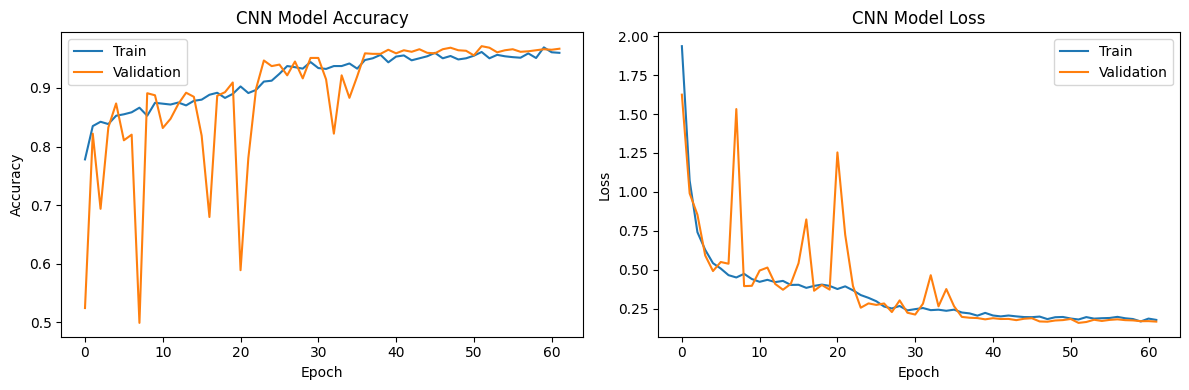

In [ ]:
  plot_training_history(cnn_history, 'CNN')

80/80 ━━━━━━━━━━━━━━━━━━━━ 604s 8s/step - accuracy: 0.9708 - loss: 0.1688 - precision: 0.9811 - recall: 0.9619
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step

CNN Test Results:
Loss: 0.1650
Accuracy: 0.9716
Precision: 0.9731
Recall: 0.9731

CNN Classification Report:
              precision    recall  f1-score   support

Non-Violence       0.45      0.45      0.45       598
    Violence       0.51      0.51      0.51       669

    accuracy                           0.48      1267
   macro avg       0.48      0.48      0.48      1267
weighted avg       0.48      0.48      0.48      1267



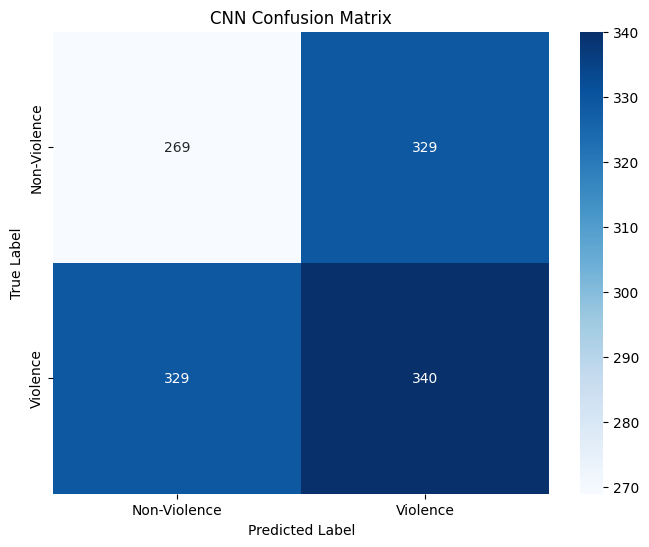

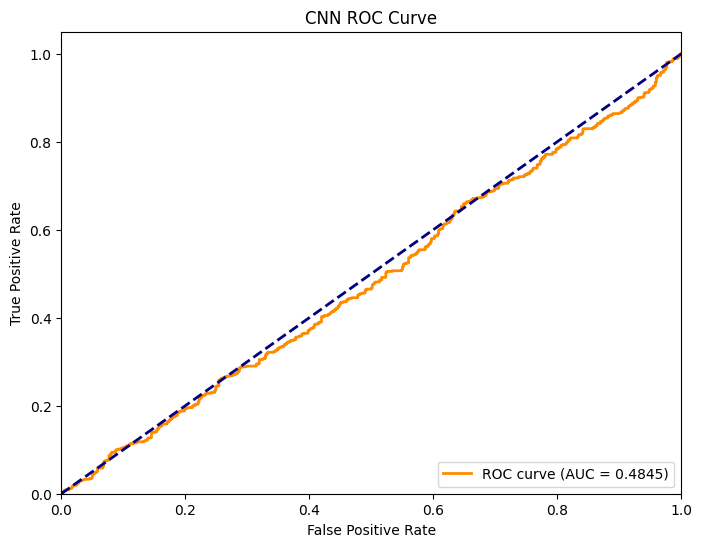

In [ ]:
  cnn_results = evaluate_model(cnn_model, test_generator, 'CNN')

## LSTM

### Training Data

In [ ]:
  # Train and evaluate LSTM
  print("\nTraining LSTM model...")
  lstm_model = build_lstm_model()
  lstm_history = train_model(lstm_model, 'lstm', train_generator, validation_generator)

128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 254ms/step - accuracy: 0.9914 - loss: 0.0322 - precision_1: 0.9886 - recall_1: 0.9953 - val_accuracy: 0.9852 - val_loss: 0.0399 - val_precision_1: 0.9966 - val_recall_1: 0.9750 - learning_rate: 4.0000e-05


### Evaluation

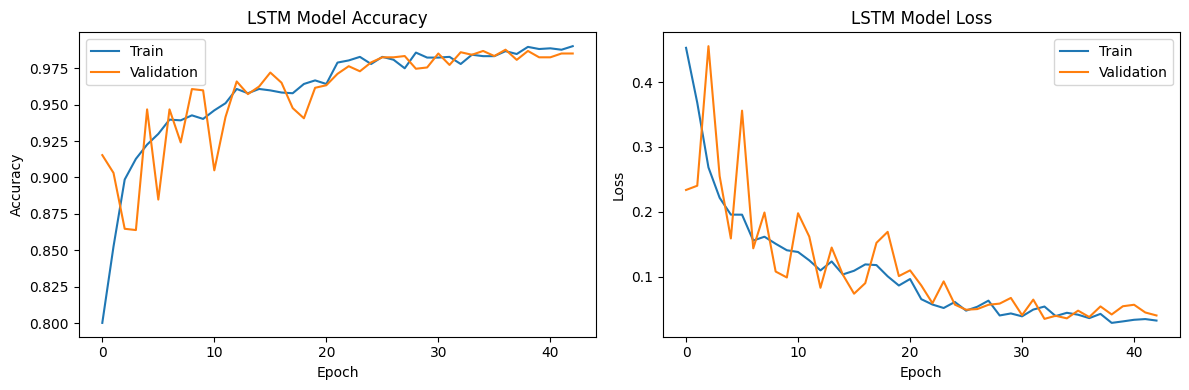

In [ ]:
  plot_training_history(lstm_history, 'LSTM')

80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.9932 - loss: 0.0241 - precision_1: 0.9983 - recall_1: 0.9887
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step

LSTM Test Results:
Loss: 0.0281
Accuracy: 0.9874
Precision: 0.9970
Recall: 0.9791

LSTM Classification Report:
              precision    recall  f1-score   support

Non-Violence       0.44      0.45      0.45       598
    Violence       0.50      0.49      0.50       669

    accuracy                           0.47      1267
   macro avg       0.47      0.47      0.47      1267
weighted avg       0.47      0.47      0.47      1267



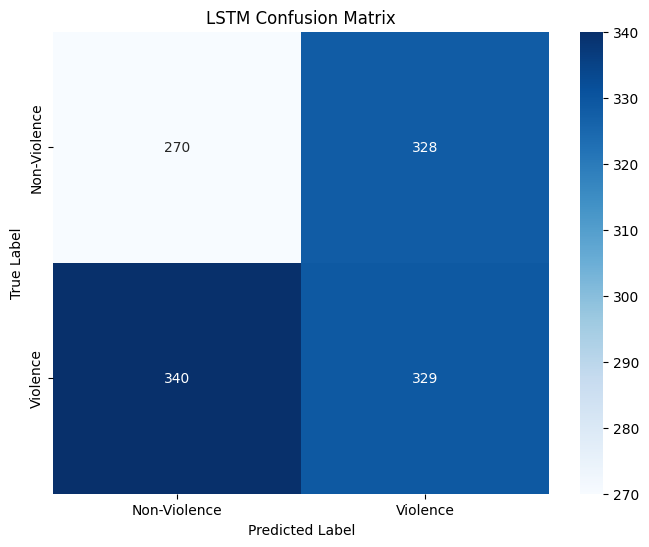

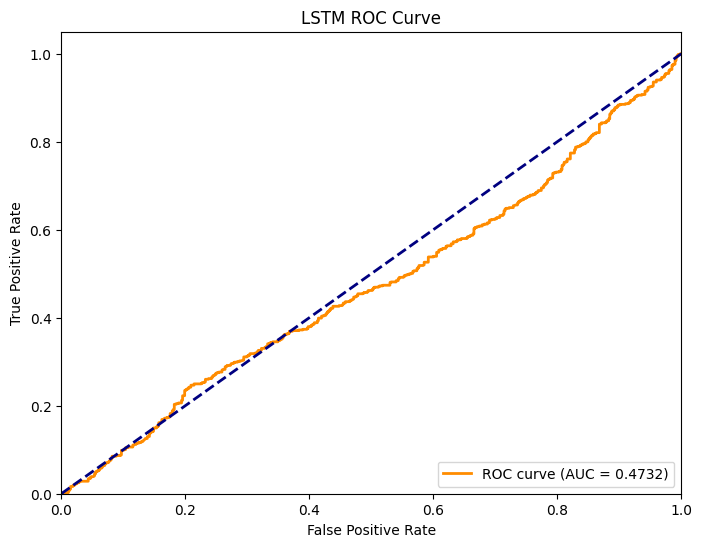

In [ ]:
  lstm_results = evaluate_model(lstm_model, test_generator, 'LSTM')

## Transfer Learning CNN & LSTM Model

### Transfer Learning CNN - Training Data

In [ ]:
  print("\nTraining Transfer Learning CNN model...")
  transfer_cnn = build_transfer_learning_cnn(cnn_model)
  transfer_cnn_history = train_model(transfer_cnn, 'transfer_cnn', train_generator, validation_generator)

128/128 ━━━━━━━━━━━━━━━━━━━━ 36s 266ms/step - accuracy: 0.8124 - loss: 0.5157 - precision_2: 0.7821 - recall_2: 0.8896 - val_accuracy: 0.8360 - val_loss: 0.4610 - val_precision_2: 0.8566 - val_recall_2: 0.8253 - learning_rate: 8.0000e-06
Epoch 43/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 260ms/step - accuracy: 0.8110 - loss: 0.5162 - precision_2: 0.7858 - recall_2: 0.8905 - val_accuracy: 0.8272 - val_loss: 0.4735 - val_precision_2: 0.8657 - val_recall_2: 0.7937 - learning_rate: 8.0000e-06


### Transfer Learning CNN - Evaluation

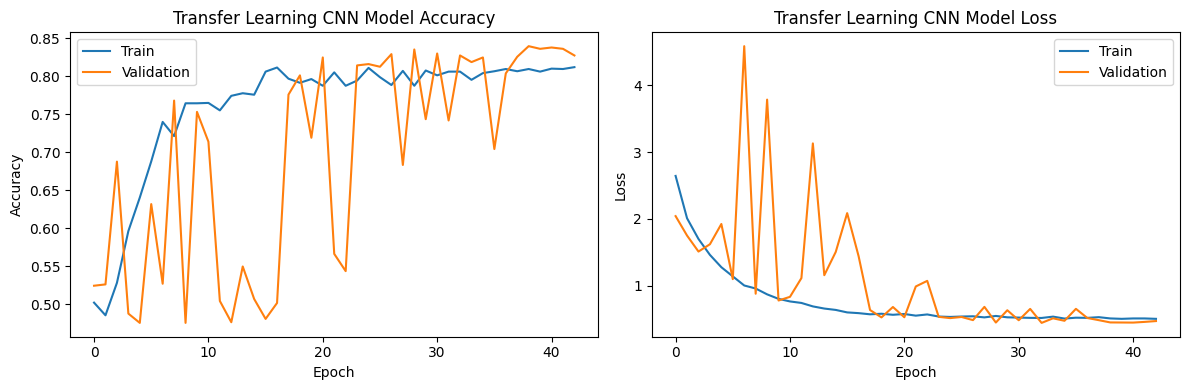

In [ ]:
  plot_training_history(transfer_cnn_history, 'Transfer Learning CNN')

80/80 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step

Transfer Learning CNN Test Results:
Loss: 0.4819
Accuracy: 0.8043
Precision: 0.7654
Recall: 0.9073

Transfer Learning CNN Classification Report:
              precision    recall  f1-score   support

Non-Violence       0.44      0.35      0.39       598
    Violence       0.51      0.60      0.55       669

    accuracy                           0.48      1267
   macro avg       0.47      0.48      0.47      1267
weighted avg       0.48      0.48      0.47      1267



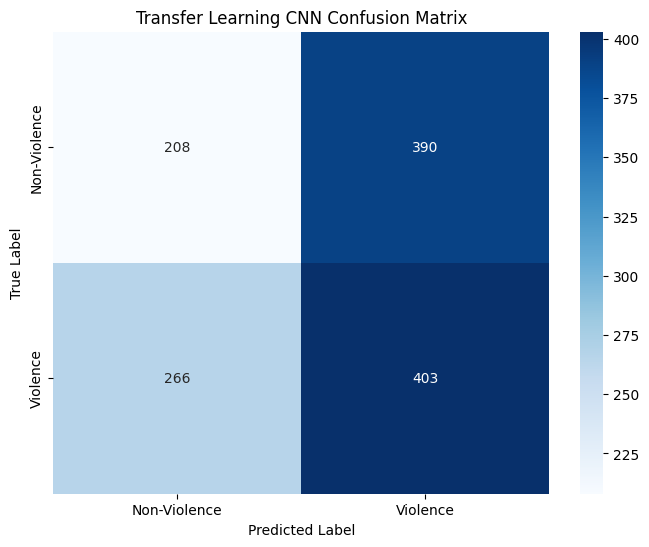

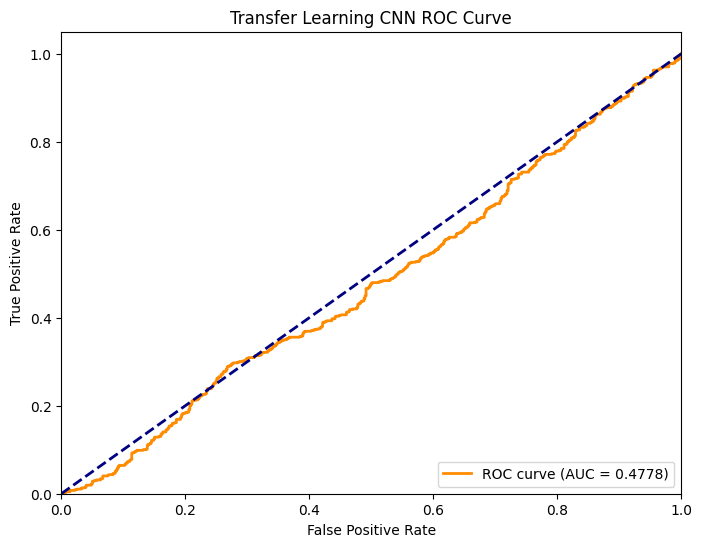

In [ ]:
  transfer_cnn_results = evaluate_model(transfer_cnn, test_generator, 'Transfer Learning CNN')

### Transfer Learning CNN - Fine Tuning

128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 259ms/step - accuracy: 0.8617 - loss: 0.3573 - precision_3: 0.8390 - recall_3: 0.9108 - val_accuracy: 0.8700 - val_loss: 0.3143 - val_precision_3: 0.8870 - val_recall_3: 0.8619 - learning_rate: 8.0000e-06
Epoch 63/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 257ms/step - accuracy: 0.8559 - loss: 0.3689 - precision_3: 0.8225 - recall_3: 0.9181 - val_accuracy: 0.8682 - val_loss: 0.3083 - val_precision_3: 0.8763 - val_recall_3: 0.8719 - learning_rate: 8.0000e-06


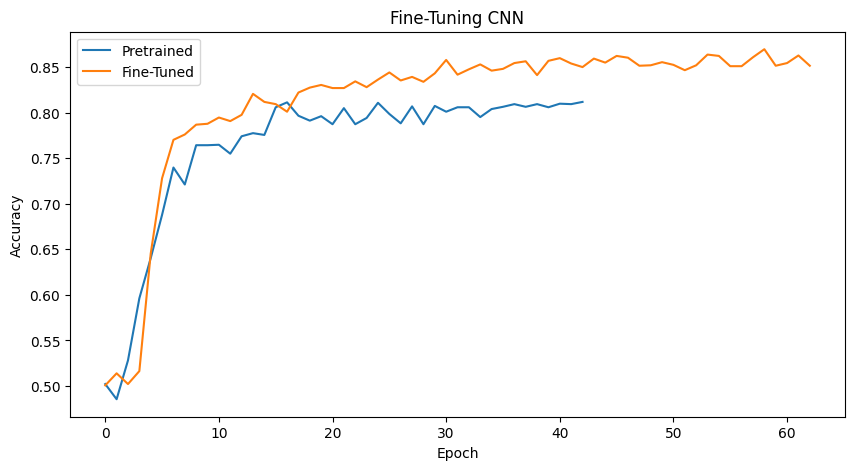

In [ ]:
  # Compare with Fine Tuning
  fine_tune_cnn = build_transfer_learning_cnn(cnn_model, fine_tune_at=140)
  fine_tune_history_cnn = train_model(fine_tune_cnn, 'fine_tune_cnn', train_generator, validation_generator)
  plot_fine_tuning_comparison(transfer_cnn_history, fine_tune_history_cnn, 'Fine-Tuning CNN', metric='accuracy')

### Transfer Learning LSTM - Training Data

In [ ]:
  # Build and train Transfer Learning LSTM
  print("\nTraining Transfer Learning LSTM model...")
  transfer_lstm = build_transfer_learning_lstm(lstm_model)
  transfer_lstm_history = train_model(transfer_lstm, 'transfer_lstm', train_generator, validation_generator)

128/128 ━━━━━━━━━━━━━━━━━━━━ 34s 258ms/step - accuracy: 0.5415 - loss: 0.6909 - precision_4: 0.5423 - recall_4: 0.9972 - val_accuracy: 0.5244 - val_loss: 0.6920 - val_precision_4: 0.5244 - val_recall_4: 1.0000 - learning_rate: 4.0000e-05


### Transfer Learning LSTM - Evaluation

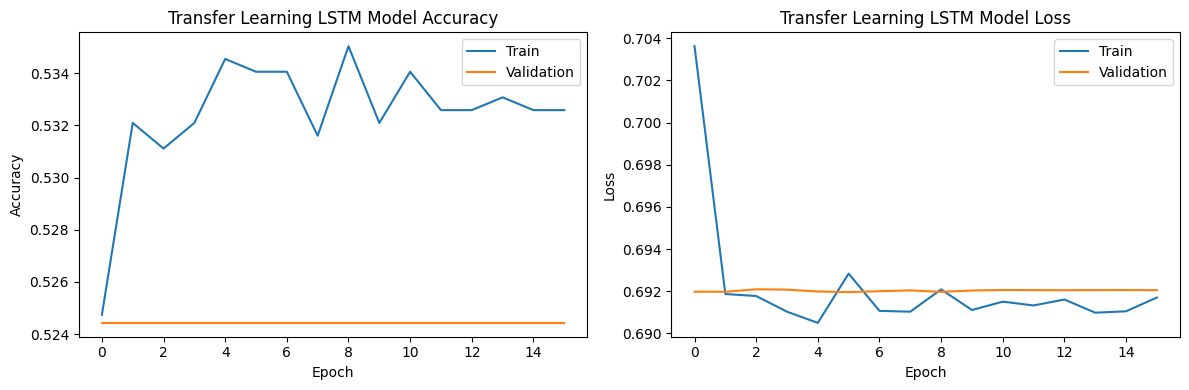

In [ ]:
  plot_training_history(transfer_lstm_history, 'Transfer Learning LSTM')

80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.5267 - loss: 0.6917 - precision_4: 0.5267 - recall_4: 1.0000
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step

Transfer Learning LSTM Test Results:
Loss: 0.6916
Accuracy: 0.5280
Precision: 0.5280
Recall: 1.0000

Transfer Learning LSTM Classification Report:
              precision    recall  f1-score   support

Non-Violence       0.00      0.00      0.00       598
    Violence       0.53      1.00      0.69       669

    accuracy                           0.53      1267
   macro avg       0.26      0.50      0.35      1267
weighted avg       0.28      0.53      0.36      1267



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


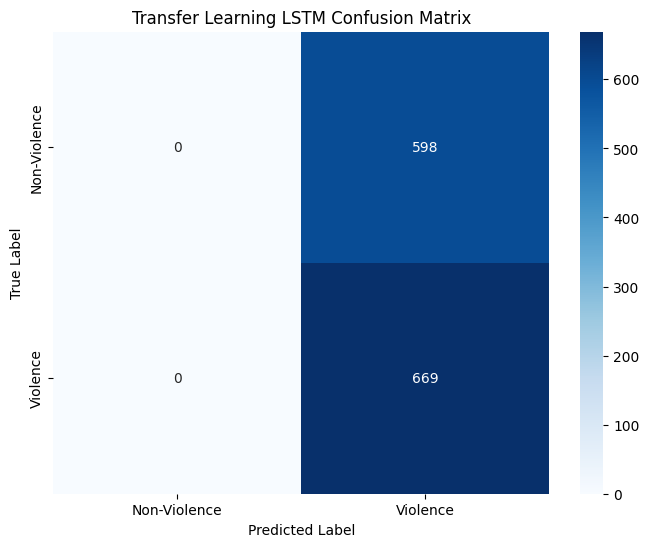

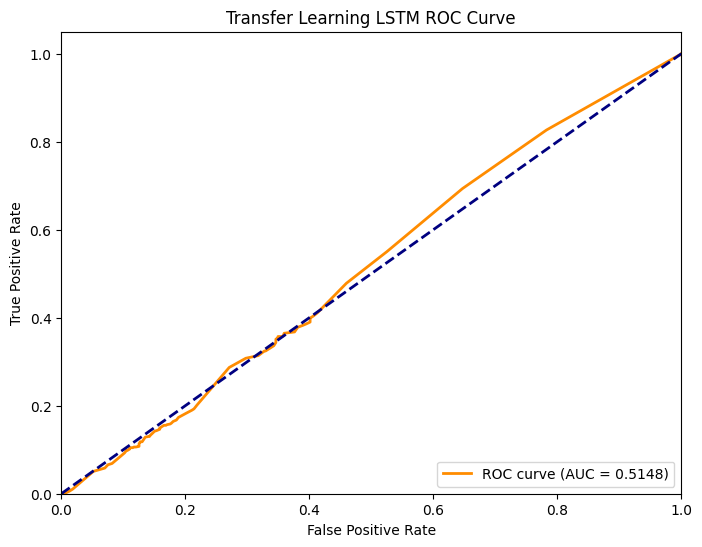

In [ ]:
  transfer_lstm_results = evaluate_model(transfer_lstm, test_generator, 'Transfer Learning LSTM')

### Transfer Learning LSTM - Fine Tuning

128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 263ms/step - accuracy: 0.5378 - loss: 0.6907 - precision_5: 0.5378 - recall_5: 1.0000 - val_accuracy: 0.5244 - val_loss: 0.6920 - val_precision_5: 0.5244 - val_recall_5: 1.0000 - learning_rate: 2.0000e-04
Epoch 13/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 35s 262ms/step - accuracy: 0.5170 - loss: 0.6935 - precision_5: 0.5170 - recall_5: 1.0000 - val_accuracy: 0.5244 - val_loss: 0.6920 - val_precision_5: 0.5244 - val_recall_5: 1.0000 - learning_rate: 2.0000e-04


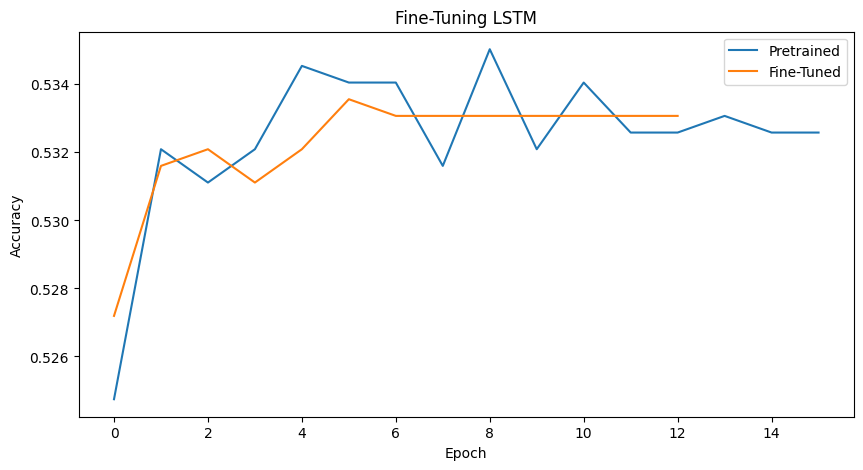

In [ ]:
  # Compare with Fine Tuning
  fine_tune_lstm = build_transfer_learning_lstm(lstm_model, fine_tune_at=140)
  fine_tune_history_lstm = train_model(fine_tune_lstm, 'fine_tune_lstm', train_generator, validation_generator)
  plot_fine_tuning_comparison(transfer_lstm_history, fine_tune_history_lstm, 'Fine-Tuning LSTM', metric='accuracy')

## Meta Learning

In [ ]:
  meta_batch_size = BATCH_SIZE * 6
  train_generator, validation_generator, test_generator = prepare_data(
    output_directory,
    batch_size=meta_batch_size
  )

Found 2041 images belonging to 2 classes.
Found 1146 images belonging to 2 classes.
Found 1267 images belonging to 2 classes.


### Meta Learning CNN - Training Data

In [ ]:
  print("\nTraining Meta Learning CNN...")
  meta_cnn_model, meta_cnn_train_losses, meta_cnn_val_losses = train_meta_model(
      cnn_model,
      train_generator,
      validation_generator
  )

Successfully created 10 tasks
Meta-train loss: 0.0777
Successfully created 5 tasks
Meta-val loss: 0.2105

Epoch 17/50
Successfully created 10 tasks
Meta-train loss: 0.0987
Successfully created 5 tasks
Meta-val loss: 0.0201

Early stopping triggered after 17 epochs


### Meta Learning CNN - Evaluation

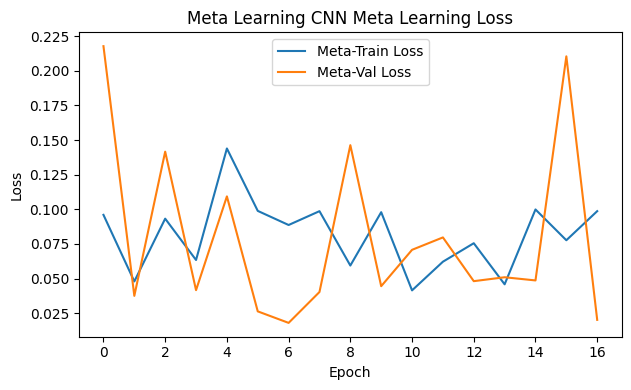

In [ ]:
  # Plot Meta CNN training history
  plot_meta_training_history(
      meta_cnn_train_losses,
      meta_cnn_val_losses,
      'Meta Learning CNN'
  )

Successfully created 20 tasks

Meta Learning CNN Meta-Learning Test Results:
Average Accuracy: 0.9500
Average Precision: 0.9800
Average Recall: 0.9250


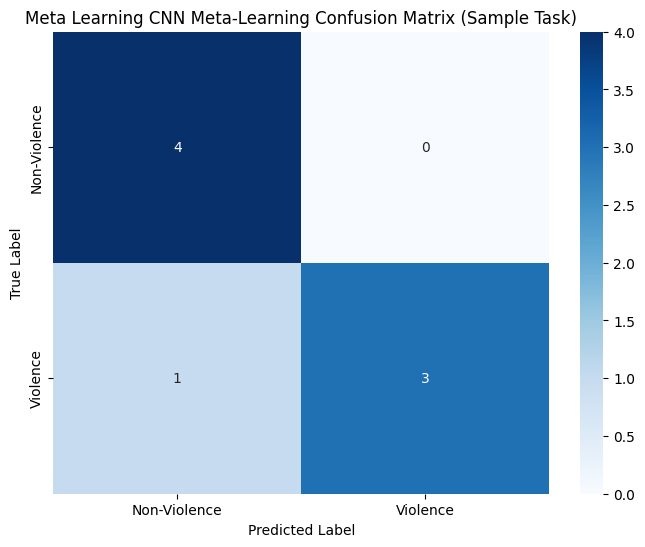

In [ ]:
  # Evaluate Meta CNN
  meta_cnn_results = evaluate_meta_model(
    meta_cnn_model,
    test_generator,
    'Meta Learning CNN'
  )

### Meta Learning LSTM - Training Data

In [ ]:
  print("\nTraining Meta Learning LSTM...")
  meta_lstm_model, meta_lstm_train_losses, meta_lstm_val_losses = train_meta_model(
      lstm_model,
      train_generator,
      validation_generator
  )

Successfully created 10 tasks
Meta-train loss: 0.5695
Successfully created 5 tasks
Meta-val loss: 0.5789

Epoch 13/50
Successfully created 10 tasks
Meta-train loss: 0.5945
Successfully created 5 tasks
Meta-val loss: 0.5065

Epoch 14/50
Successfully created 10 tasks
Meta-train loss: 0.5613
Successfully created 5 tasks
Meta-val loss: 0.5531

Early stopping triggered after 14 epochs


### Meta Learning LSTM - Evaluation

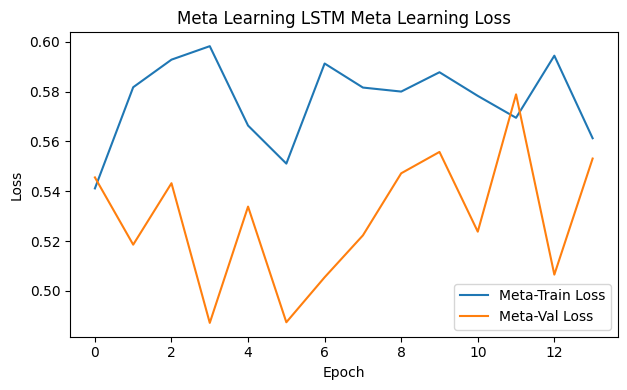

In [ ]:
  # Plot Meta LSTM training history
  plot_meta_training_history(
      meta_lstm_train_losses,
      meta_lstm_val_losses,
      'Meta Learning LSTM'
  )


Meta Learning LSTM Meta-Learning Test Results:
Average Accuracy: 0.5125
Average Precision: 0.5071
Average Recall: 1.0000


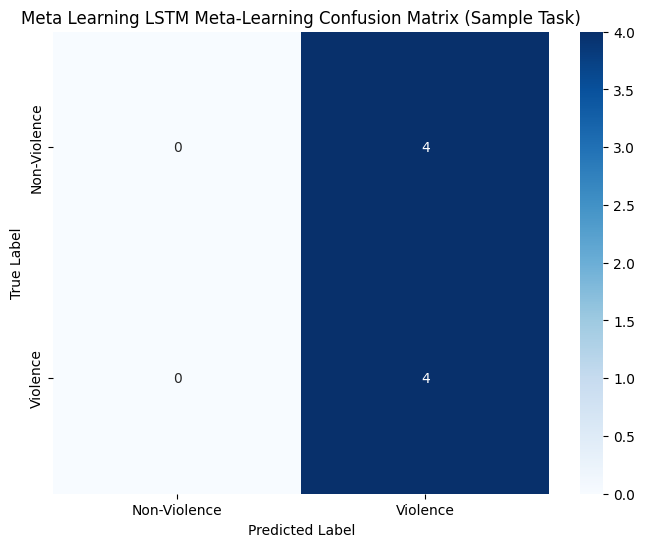

In [ ]:
  # Evaluate Meta LSTM
  meta_lstm_results = evaluate_meta_model(
      meta_lstm_model,
      test_generator,
      'Meta Learning LSTM'
  )

## Vision Transformer

In [ ]:
  device = "cuda" if torch.cuda.is_available() else "cpu"
  device

'cuda'

In [ ]:
  # 1. Get pretrained weights for ViT-Base
  pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

  # 2. Setup a ViT model instance with pretrained weights
  pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

  # 3. Freeze the base parameters
  for parameter in pretrained_vit.parameters():
      parameter.requires_grad = False

  # 4. Change the classifier head
  class_names = ['non_violence', 'violence']

  set_seeds()
  pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
  # pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 228MB/s]


In [ ]:
  # Print a summary using torchinfo (uncomment for actual output)
  summary(model=pretrained_vit,
          input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
          # col_names=["input_size"], # uncomment for smaller output
          col_names=["input_size", "output_size", "num_params", "trainable"],
          col_width=20,
          row_settings=["var_names"]
  )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [ ]:
  # Get automatic transforms from pretrained ViT weights
  pretrained_vit_transforms = pretrained_vit_weights.transforms()
  print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [ ]:
  train_dir = '/content/drive/MyDrive/Datasets/dataset_split/train'
  test_dir = '/content/drive/MyDrive/Datasets/dataset_split/test'

  # Setup dataloaders
  train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(
      train_dir=train_dir,
      test_dir=test_dir,
      transform=pretrained_vit_transforms,
      batch_size=32
  )

In [ ]:
  # Class Names
  class_names = train_dataloader_pretrained.dataset.classes

In [ ]:
  # Early stopping utility to stop training when validation loss does not improve.
  class EarlyStopping:
      def __init__(self, patience=5, delta=0):
          self.patience = patience
          self.delta = delta
          self.best_loss = float("inf")
          self.counter = 0
          self.early_stop = False

      def __call__(self, val_loss):
          if val_loss < self.best_loss - self.delta:
              self.best_loss = val_loss
              self.counter = 0
          else:
              self.counter += 1
              if self.counter >= self.patience:
                  self.early_stop = True

In [ ]:
  import torch
  from torch.optim import Adam
  from torch.nn import CrossEntropyLoss
  from torch.utils.data import DataLoader

  # Define optimizer with parameters inspired by the pretrained_vit paper
  optimizer = Adam(
      params=pretrained_vit.parameters(),
      lr=3e-3,  # Learning rate from the pretrained_vit paper
      betas=(0.9, 0.999),  # Default values
      weight_decay=0.3  # Weight decay from the pretrained_vit paper
  )

  # Define loss function
  loss_fn = CrossEntropyLoss()

  # Training loop
  epochs = EPOCHS
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  pretrained_vit.to(device)

  # Initialize lists to store metrics
  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  # Initialize early stopping
  early_stopping = EarlyStopping(patience=5, delta=0.001)

  for epoch in range(epochs):
      # Training phase
      pretrained_vit.train()
      train_loss = 0
      correct_train = 0
      total_train = 0
      for images, labels in train_dataloader_pretrained:
          images, labels = images.to(device), labels.to(device)

          # Forward pass
          outputs = pretrained_vit(images)
          loss = loss_fn(outputs, labels)

          # Backward pass and optimization
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          train_loss += loss.item()
          _, predicted = torch.max(outputs, 1)
          correct_train += (predicted == labels).sum().item()
          total_train += labels.size(0)

      train_losses.append(train_loss / len(train_dataloader_pretrained))
      train_accuracies.append(correct_train / total_train)

      # Validation phase
      pretrained_vit.eval()
      val_loss = 0
      correct_val = 0
      total_val = 0
      with torch.no_grad():
          for images, labels in test_dataloader_pretrained:
              images, labels = images.to(device), labels.to(device)
              outputs = pretrained_vit(images)
              loss = loss_fn(outputs, labels)
              val_loss += loss.item()
              _, predicted = torch.max(outputs, 1)
              correct_val += (predicted == labels).sum().item()
              total_val += labels.size(0)

      val_losses.append(val_loss / len(test_dataloader_pretrained))
      val_accuracies.append(correct_val / total_val)

      print(f"Epoch {epoch + 1}/{epochs}, "
            f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}, "
            f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}")

      # Early stopping check
      early_stopping(val_losses[-1])
      if early_stopping.early_stop:
          print("Early stopping triggered!")
          break


Epoch 7/100, Train Loss: 0.0934, Train Accuracy: 0.98, Validation Loss: 0.0913, Validation Accuracy: 0.99
Epoch 8/100, Train Loss: 0.0899, Train Accuracy: 0.99, Validation Loss: 0.0835, Validation Accuracy: 0.99
Early stopping triggered!


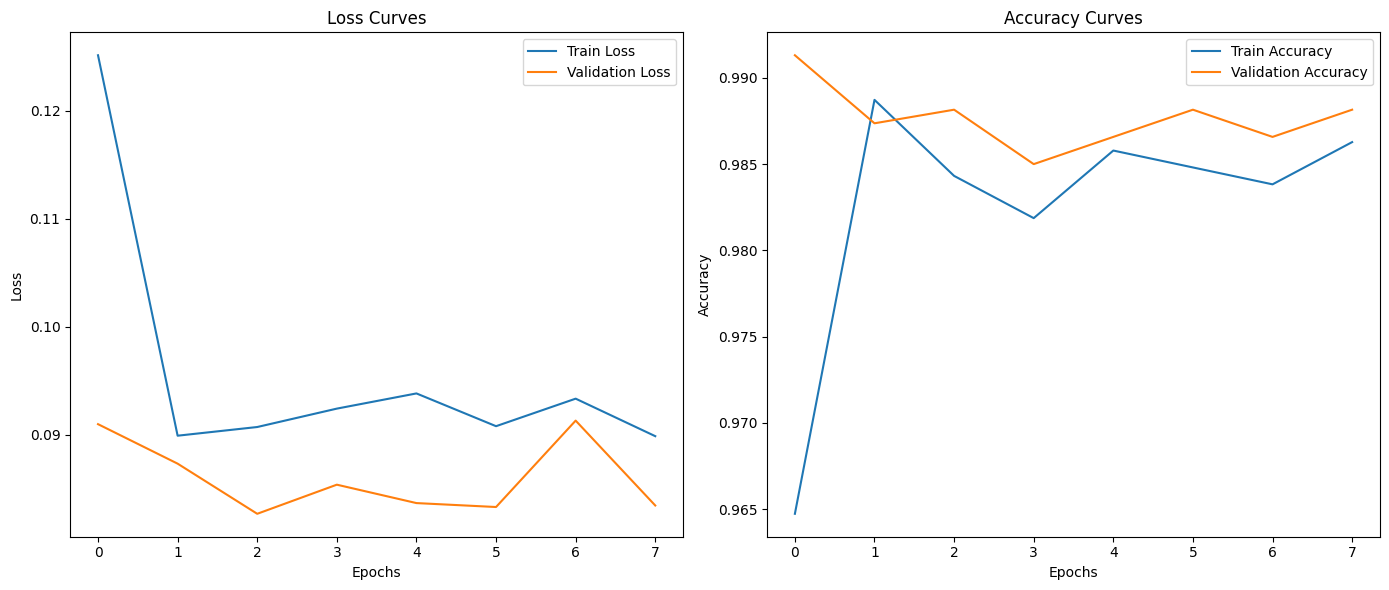

In [ ]:
  # Plot accuracy and loss curves
  plt.figure(figsize=(14, 6))

  # Plot loss curves
  plt.subplot(1, 2, 1)
  plt.plot(train_losses, label="Train Loss")
  plt.plot(val_losses, label="Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.title("Loss Curves")
  plt.legend()

  # Plot accuracy curves
  plt.subplot(1, 2, 2)
  plt.plot(train_accuracies, label="Train Accuracy")
  plt.plot(val_accuracies, label="Validation Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.title("Accuracy Curves")
  plt.legend()

  plt.tight_layout()
  plt.show()

In [ ]:
  # Define a function to predict and plot the image
  def pred_and_plot_image(model, image_path, class_names, transform=None, device="cpu"):
      # Open the image
      img = Image.open(image_path).convert("RGB")

      # Apply transformations
      if transform:
          img_transformed = transform(img).unsqueeze(0)  # Add batch dimension
      else:
          raise ValueError("A transform must be provided for preprocessing the image.")

      # Move model and image to the specified device
      model = model.to(device)
      img_transformed = img_transformed.to(device)

      # Set the model to evaluation mode and make predictions
      model.eval()
      with torch.no_grad():
          outputs = model(img_transformed)
          _, predicted_class = torch.max(outputs, 1)
          predicted_class_name = class_names[predicted_class.item()]

      # Plot the image and prediction
      plt.imshow(img)
      plt.title(f"Predicted: {predicted_class_name}")
      plt.axis("off")
      plt.show()

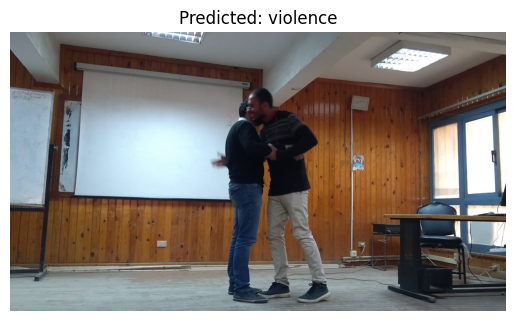

In [ ]:
  # Define transformations (matching those used during training)
  transform = transforms.Compose([
      transforms.Resize((224, 224)),  # Resize to the input size of ViT
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
  ])

  # Path to the image to predict
  custom_image_path = "/content/drive/MyDrive/Datasets/dataset_split/test/non_violence/NV_1.mp4_frame1.jpg"

  # List of class names (e.g., ['non_violence', 'violence'])
  class_names = train_dataloader_pretrained.dataset.classes

  # Predict and plot
  pred_and_plot_image(
      model=pretrained_vit,
      image_path=custom_image_path,
      class_names=class_names,
      transform=transform,
      device=device
  )

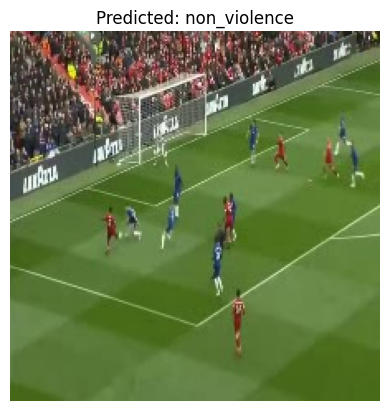

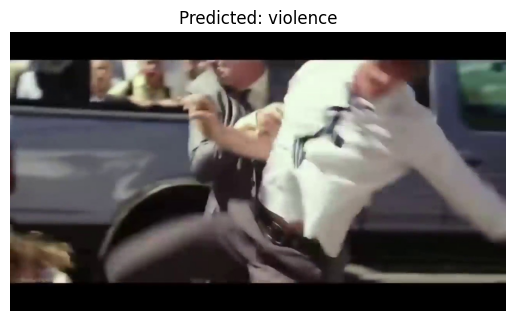

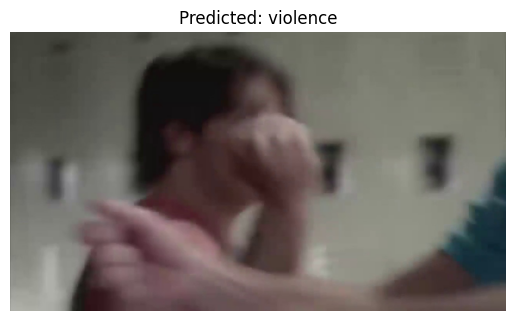

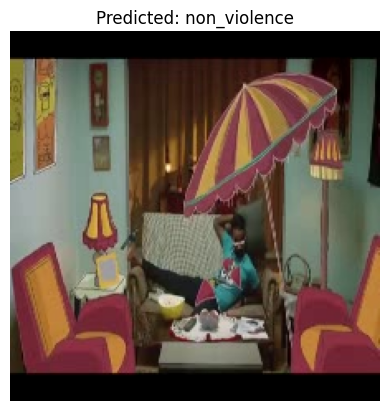

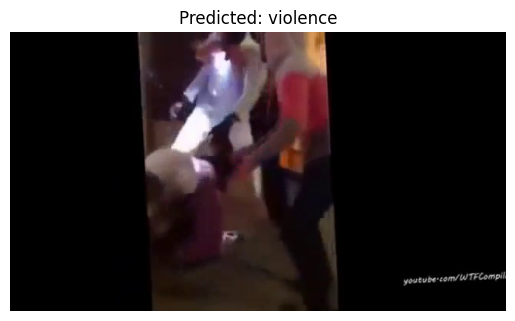

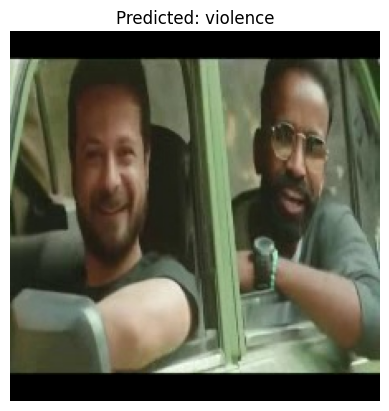

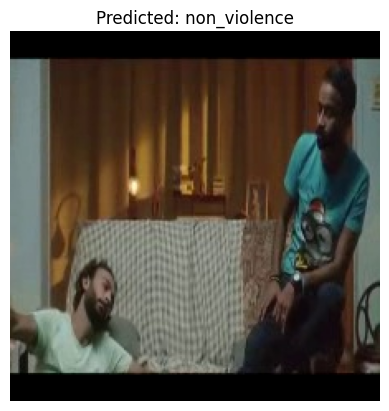

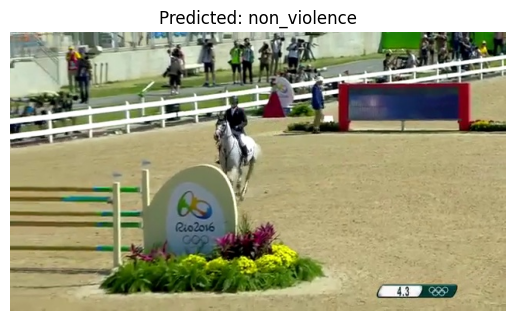

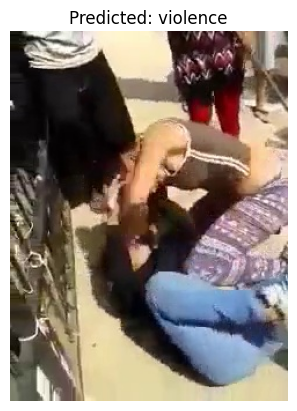

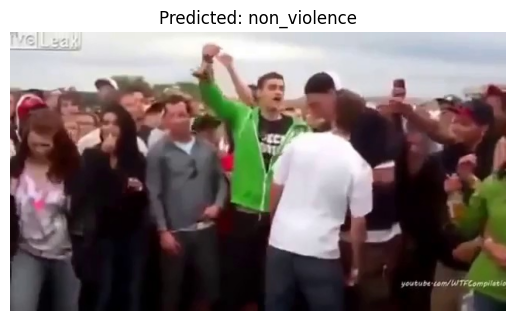

In [ ]:
  import random

  # creating paths
  paths_1 = os.path.join(train_dir, "non_violence")
  paths_2 = os.path.join(train_dir, "violence")

  # images paths
  image_set_1 = [os.path.join(paths_1, img) for img in os.listdir(paths_1)][:5]
  image_set_2 = [os.path.join(paths_2, img) for img in os.listdir(paths_2)][:5]

  # joining both the paths
  image_set = image_set_1 + image_set_2

  # shuffling the images
  random.shuffle(image_set)

  # printing 5 images
  for img in image_set:
      pred_and_plot_image(
        model=pretrained_vit,
        image_path=img,
        class_names=class_names,
        transform=transform,
        device=device
    )

In [ ]:
  from sklearn.metrics import classification_report
  # Evaluates the model on the given dataloader and returns metrics and a classification report.
  def evaluate_model_with_report(model, dataloader, device, class_names):
      model.eval()  # Set the model to evaluation mode
      loss_fn = CrossEntropyLoss()  # Use the same loss function as training
      total_loss = 0
      correct_preds = 0
      total_samples = 0
      all_preds = []
      all_labels = []

      with torch.no_grad():
          for images, labels in dataloader:
              # Move images and labels to the specified device
              images, labels = images.to(device), labels.to(device)

              # Get model outputs
              outputs = model(images)
              loss = loss_fn(outputs, labels)
              total_loss += loss.item()

              # Calculate predictions
              _, predicted = torch.max(outputs, 1)
              correct_preds += (predicted == labels).sum().item()
              total_samples += labels.size(0)

              # Store predictions and true labels for classification report
              all_preds.extend(predicted.cpu().numpy())
              all_labels.extend(labels.cpu().numpy())

      # Calculate average loss and accuracy
      avg_loss = total_loss / len(dataloader)
      accuracy = correct_preds / total_samples

      # Generate classification report
      report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)

      # Return metrics and report
      metrics = {
          "loss": avg_loss,
          "accuracy": accuracy,
      }
      return metrics, report

In [ ]:
  # Evaluate the trained ViT model with classification report
  evaluation_metrics, clf_report = evaluate_model_with_report(pretrained_vit, test_dataloader_pretrained, device, class_names)

  # Print evaluation results
  print(f"Test Loss: {evaluation_metrics['loss']:.4f}")
  print(f"Test Accuracy: {evaluation_metrics['accuracy']:.2%}")

  # Print classification report
  print("\nClassification Report:")
  print(clf_report)

Test Loss: 0.0835
Test Accuracy: 98.82%

Classification Report:
{'non_violence': {'precision': 0.9932318104906938, 'recall': 0.9816053511705686, 'f1-score': 0.9873843566021867, 'support': 598.0}, 'violence': {'precision': 0.9837278106508875, 'recall': 0.9940209267563528, 'f1-score': 0.9888475836431226, 'support': 669.0}, 'accuracy': 0.9881610102604578, 'macro avg': {'precision': 0.9884798105707906, 'recall': 0.9878131389634607, 'f1-score': 0.9881159701226547, 'support': 1267.0}, 'weighted avg': {'precision': 0.9882135185468656, 'recall': 0.9881610102604578, 'f1-score': 0.9881569681968088, 'support': 1267.0}}


In [ ]:
  # Formatting the report
  formatted_report = format_classification_report(clf_report)

  # Print the result
  print(f"Test Loss: 0.3204\nTest Accuracy: {clf_report['accuracy'] * 100:.2f}%\n")
  print(formatted_report)

Test Loss: 0.3204
Test Accuracy: 98.82%

Classification Report:
Class               precision   recall      f1-score    support   
non_violence        0.99        0.98        0.99        598.0     
violence            0.98        0.99        0.99        669.0     

accuracy            0.99        
macro avg           0.99        0.99        0.99        1267.0    
weighted avg        0.99        0.99        0.99        1267.0    



In [ ]:
  torchvision_history = {
      'train_acc': train_accuracies,
      'val_acc': val_accuracies,
      'train_loss': train_losses,
      'val_loss': val_losses
  }

  torchvision_results = {
      'accuracy': evaluation_metrics['accuracy'],
      'precision': clf_report['macro avg']['precision'],
      'recall': clf_report['macro avg']['recall']
  }

## Visualization of comparison across all models

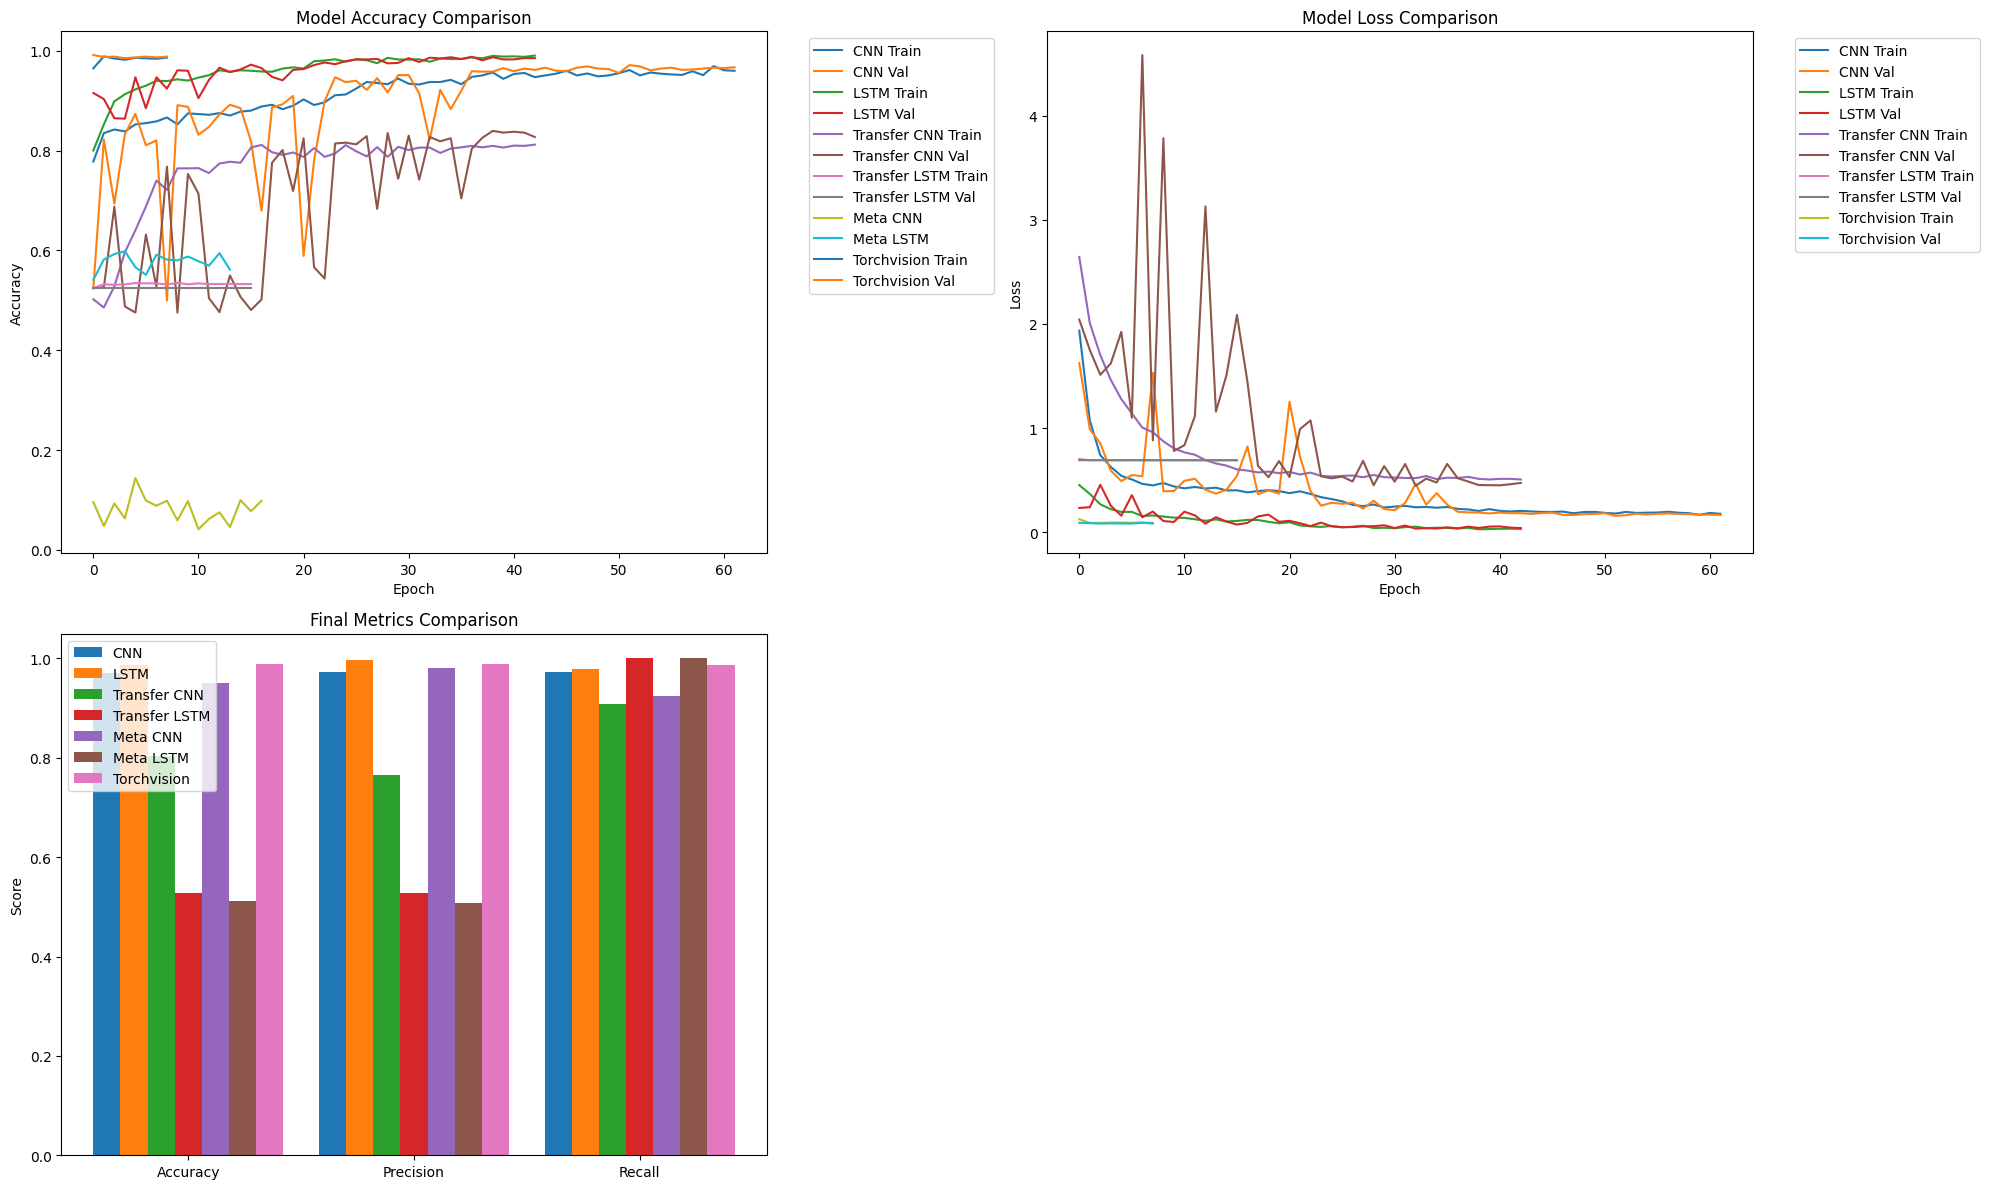


Model Comparison Summary:
------------------------------------------------------------------------------------------------------------------------
Metric       |    CNN    |    LSTM   | Transfer CNN | Transfer LSTM | Meta CNN  | Meta LSTM | Torchvision
------------------------------------------------------------------------------------------------------------------------
Accuracy    |  0.9716  |  0.9874  |    0.8043    |    0.5280    |  0.9500 |  0.5125 |   0.9882
Precision   |  0.9731  |  0.9970  |    0.7654    |    0.5280    |  0.9800 |  0.5071 |   0.9885
Recall      |  0.9731  |  0.9791  |    0.9073    |    1.0000    |  0.9250 |  1.0000 |   0.9878
------------------------------------------------------------------------------------------------------------------------

Training Time and Convergence Comparison:
------------------------------------------------------------------------------------------------------------------------
Model         | Total Epochs | Best Val Accuracy | Best

In [ ]:
  # Compare all models
  compare_models(
    cnn_history,
    lstm_history,
    transfer_cnn_history,
    transfer_lstm_history,
    meta_cnn_train_losses,
    meta_lstm_train_losses,
    torchvision_history,
    cnn_results[0],
    lstm_results[0],
    transfer_cnn_results[0],
    transfer_lstm_results[0],
    meta_cnn_results,
    meta_lstm_results,
    torchvision_results
  )